In [1]:
import numpy as np
import sys
import gsw
import xarray as xr
import numpy as np
from scipy import integrate
from copy import deepcopy 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [3]:
## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
# ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['SSHDYN','OBPNOPAB', 'RHOAnoma'], \
#                                                              years_to_load=range(2011,2018)).load() # ,'PHIHYD','RHOAnoma','SALT','UVEL','VVEL'    
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['ETAN', 'PHIBOT'],\
                                           years_to_load=range(2013,2018)).load()    
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  ETAN
loading files of  PHIBOT


In [4]:
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)

In [5]:
# LLC270
# load steric height and steric pressure already computed 
ds_den0 = '/Users/jakesteinberg/Documents/NASA_OSTST/rho_270_steric_2013.nc'
ds_den1 = '/Users/jakesteinberg/Documents/NASA_OSTST/rho_270_steric_2014.nc'
ds_den2 = '/Users/jakesteinberg/Documents/NASA_OSTST/rho_270_steric_2015.nc'
ds_den3 = '/Users/jakesteinberg/Documents/NASA_OSTST/rho_270_steric_2016.nc'
ds_den4 = '/Users/jakesteinberg/Documents/NASA_OSTST/rho_270_steric_2017.nc'
ds_den01 = xr.open_dataset(ds_den0); ds_den11 = xr.open_dataset(ds_den1);
ds_den21 = xr.open_dataset(ds_den2); ds_den31 = xr.open_dataset(ds_den3);
ds_den41 = xr.open_dataset(ds_den4)

In [171]:
ecco_monthly_ds

<xarray.Dataset>
Dimensions:   (k_p1: 51, j_g: 270, i_g: 270, k: 50, j: 270, k_u: 50, i: 270, k_l: 50, tile: 13, time: 60)
Coordinates: (12/40)
  * k_p1      (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j         (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...        ...
    hFacW     (k, tile, j, i_g) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    maskW     (k, tile, j, i_g) bool False False False ... False False False
    maskC     (k, tile, j, i) bool False False False False ... False False False
    maskS     (k, tile, j_g, i) bool False False False ... False False False
    timestep  (time) int64 554544 556560 558792 560952 ... 679392 681552 683784
  * time      (time) datetime64[ns] 2013-01-16T12:00:00 ... 2017-12-16T12:00:00
Data variables:
    ETAN      (time, tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PHIBOT    (time, tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:           CF-1.6
    Insitution:            JPL
    Metadata_Conventions:  CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    Project:               Estimating the Circulation and Climate of the Ocean
    author:                Ou Wang
    cdm_data_type:         Grid
    date_created:          Thu Jul 30 16:52:31 2020
    no_data:               NaNf
    nz:                    50
    product_version:       ECCO Version 4 Release 5 Alpha
    title:                 ECCOv5 MITgcm grid information

In [6]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
# XC distance from grid center point to center point 
# XG distance from grid egde (where u is defined) to grid edge (finite difference of values at XC will be placed here)
grid = Grid(ecco_monthly_ds, metrics=metrics)

In [7]:
tile_num=10
lon_range = [-108, -40] # [-128,-40]
lat_range = [15, 40] # [15, 50]
# -- pull out lats and lons
lons = ecco_monthly_ds.XC.sel(tile=tile_num)
lats = ecco_monthly_ds.YC.sel(tile=tile_num)
lons_g = ecco_monthly_ds.XG.sel(tile=tile_num)
lats_g = ecco_monthly_ds.YG.sel(tile=tile_num)

In [8]:
# bathymetry
dep = ecco_monthly_ds.Depth
dep = dep.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

In [162]:
# !! -- LLC270 -- 
g = 9.81 
rho0 = 1035
# -- SLA --  
ssh_anom = ecco_monthly_ds.ETAN-ecco_monthly_ds.ETAN.mean(dim='time')
pssh = ssh_anom.polyfit(dim='time', deg=1)
ssh_a_trend = xr.polyval(ssh_anom['time'], pssh.polyfit_coefficients)
ssh_a_detrend = ssh_anom - ssh_a_trend
s_press = rho0*g*(ssh_a_detrend)
s_press = s_press.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# -- OBP --  
obp_cor = 1029*(ecco_monthly_ds.PHIBOT + g*dep)
obp_anom = obp_cor-obp_cor.mean(dim='time')
pobp = obp_anom.polyfit(dim='time', deg=1)
obp_a_trend = xr.polyval(obp_anom['time'], pobp.polyfit_coefficients)
obp_a_detrend = obp_anom - obp_a_trend
obp = (obp_a_detrend)
obp = obp.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# -- Steric Height -- 
ds_den = xr.concat([ds_den01.steric_p, ds_den11.steric_p, ds_den21.steric_p, ds_den31.steric_p, ds_den41.steric_p], dim="time")
ster_a = 1*(ds_den-ds_den.mean(dim='time'))
pster = ster_a.polyfit(dim='time', deg=1)
ster_a_trend = xr.polyval(ster_a['time'], pster.polyfit_coefficients)
ster_a_detrend = ster_a - ster_a_trend
ster = ster_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# -- density anomalies (my estimate) -- 
ds_den_r = xr.concat([ds_den01.rho, ds_den11.rho, ds_den21.rho, ds_den31.rho, ds_den41.rho], dim="time")
rho_a = ds_den_r - ds_den_r.mean(dim='time')
p = rho_a.polyfit(dim='time', deg=1)
rho_a_trend = xr.polyval(rho_a['time'], p.polyfit_coefficients)
rho_a_detrend = rho_a - rho_a_trend
rho = rho_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

In [10]:
# AVISO SLA 
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_obs_ssh_allsat_l4_pt25deg_P1D_1644446947552_2011_2017.nc'
av = xr.open_dataset(av_path)
av_time_o = np.where((av.time > ecco_monthly_ds.time[0]) & (av.time < ecco_monthly_ds.time[-1]))[0]
avsla = av.sla[av_time_o,:,:]
avsla = avsla-avsla.mean(dim='time')
pavsla = avsla.polyfit(dim='time', deg=1)
avsla_trend = xr.polyval(avsla['time'], pavsla.polyfit_coefficients)
avsla_detrend = avsla - avsla_trend

0.014884808028463972


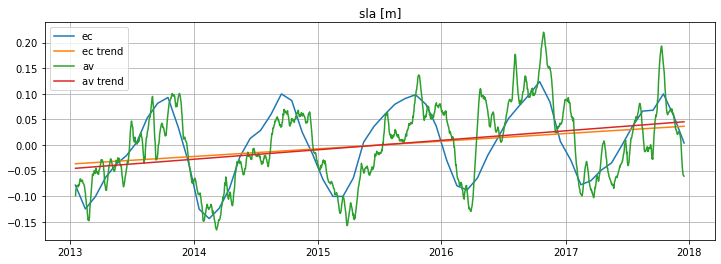

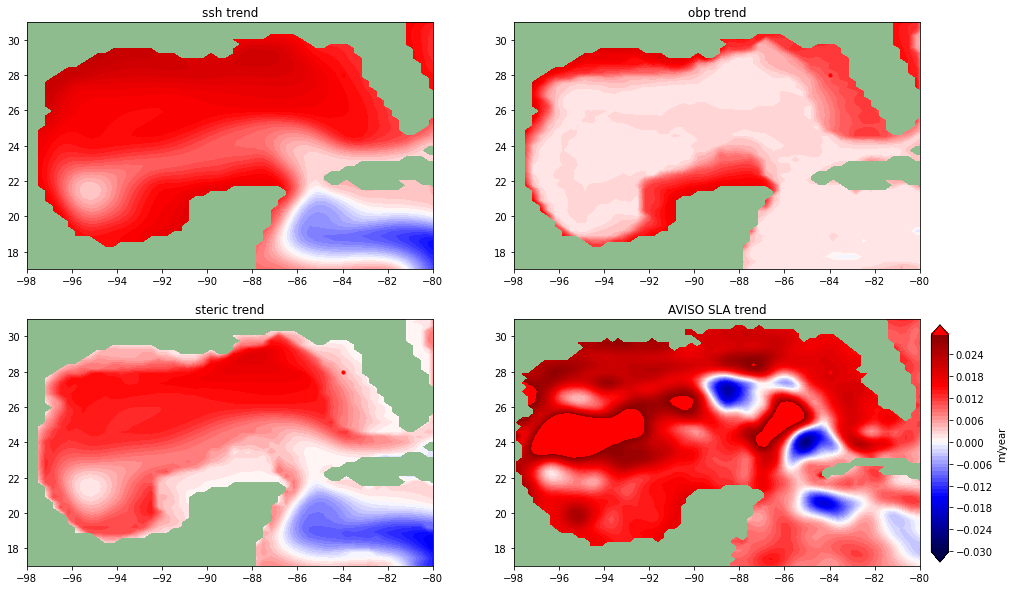

In [11]:
lon_range = [-100, -65] # [-128,-40]
lat_range = [15, 35] # [15, 50]
lon_range = [-98, -80] # [-128,-40]
lat_range = [17, 31] # [15, 50]
# pick one site to consider time series 
lon_site = -84; lat_site = 28; 
ecli = np.where((lons > lon_site-.65) & (lons < lon_site+.65) & (lats > lat_site-.65) & (lats < lat_site+.65))
eclon = lons[ecli[0][0], ecli[1][0]]; eclat = lats[ecli[0][0], ecli[1][0]]
# find aviso index to site selected above
avloni = np.where((av.longitude > eclon-.15) & (av.longitude < eclon+.15))[0][0]
avlati = np.where((av.latitude > eclat-.15) & (av.latitude < eclat+.15))[0][0]

f, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(ecco_monthly_ds.time, ssh_anom[:,tile_num,ecli[0][0], ecli[1][0]], label='ec')
ax.plot(ecco_monthly_ds.time, ssh_a_trend[:,tile_num,ecli[0][0], ecli[1][0]], label='ec trend')
ax.plot(av.time[av_time_o], avsla[:, avlati, avloni], label='av'); ax.plot(av.time[av_time_o], avsla_trend[:, avlati, avloni], label='av trend')
ax.set_title('sla [m]'); ax.legend(); ax.grid()
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_17/GOM_sla_ecco_aviso_2013_2017.jpg', dpi=250)

f, ax = plt.subplots(2,2,figsize=(16,10)); clim = [-0.03, 0.03];
colMap = plt.get_cmap('seismic'); colMap.set_over(color='r');
pssh = pssh.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
print(pssh.polyfit_coefficients[0, tile_num, ecli[0][0], ecli[1][0]].data*1e9*60*60*24*365)
ax[0,0].contourf(lons,lats,pssh.polyfit_coefficients.isel(degree=0).isel(tile=tile_num)*1e9*60*60*24*365, \
            levels=np.arange(clim[0], clim[-1],0.001), vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both'); ax[0,0].set_facecolor('#8FBC8F')
ax[0,0].scatter(lon_site,lat_site,s=10,color='r')
ax[0,0].set_title('ssh trend'); ax[0,0].set_xlim(lon_range); ax[0,0].set_ylim(lat_range); 
pobp = pobp.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
ax[0,1].contourf(lons,lats,pobp.polyfit_coefficients.isel(degree=0).isel(tile=tile_num)*1e9*60*60*24*365/g/rho0, \
            levels=np.arange(clim[0], clim[-1],0.001), vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both'); ax[0,1].set_facecolor('#8FBC8F')
ax[0,1].scatter(lon_site,lat_site,s=10,color='r')
ax[0,1].set_title('obp trend'); ax[0,1].set_xlim(lon_range); ax[0,1].set_ylim(lat_range);
pster = pster.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
ax[1,0].contourf(lons,lats,pster.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365/g/rho0, \
            levels=np.arange(clim[0], clim[-1],0.001), vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both'); ax[1,0].set_facecolor('#8FBC8F') # .isel(tile=tile_num)
ax[1,0].scatter(lon_site,lat_site,s=10,color='r')
ax[1,0].set_title('steric trend'); ax[1,0].set_xlim(lon_range); ax[1,0].set_ylim(lat_range)
Kc = ax[1,1].contourf(av.longitude,av.latitude,pavsla.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365, \
            levels=np.arange(clim[0], clim[-1], 0.001), vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both'); ax[1,1].set_facecolor('#8FBC8F')
ax[1,1].scatter(lon_site,lat_site,s=10,color='r')
ax[1,1].set_title('AVISO SLA trend'); ax[1,1].set_xlim(lon_range); ax[1,1].set_ylim(lat_range)
cbpos = [0.91, 0.13, 0.015, 0.33]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='m/year')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_17/GOM_trends_2013_2017.jpg', dpi=250)

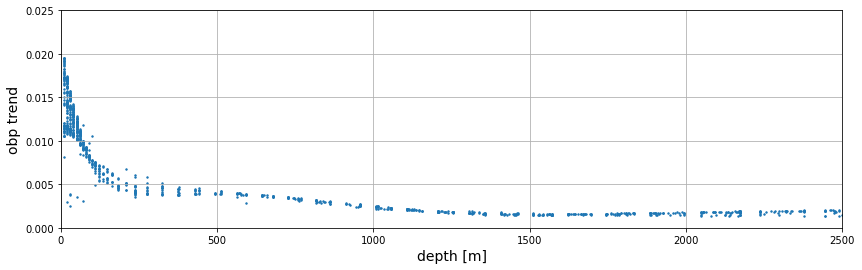

In [12]:
lon_sub = np.where((lons > lon_range[0]) & (lons < lon_range[-1]))[0]
lat_sub = np.where((lats > lat_range[0]) & (lats < lat_range[-1]))[1]
fitloc = pobp.polyfit_coefficients.isel(degree=0).isel(tile=tile_num)*1e9*60*60*24*365/g/rho0
f, ax = plt.subplots(1,1,figsize=(14,4))
ax.scatter(dep.isel(tile=tile_num).data[lon_sub[0]:lon_sub[-1],:][:,lat_sub[0]:lat_sub[-1]], \
           fitloc.data[lon_sub[0]:lon_sub[-1],:][:,lat_sub[0]:lat_sub[-1]], s=2); ax.set_xlim([0,2500]); ax.set_ylim([0,0.025]);
ax.grid(); ax.set_xlabel('depth [m]', fontsize=14); ax.set_ylabel('obp trend', fontsize=14);
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_17/GOM_obp_vs_dep.jpg', dpi=250)

In [105]:
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
gulf_mask = xr.DataArray(
    data=ocean_mask.isel(tile=tile_num),
    dims=["j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.XC.i.data), j=(["j"], ecco_monthly_ds.XC.j.data),
        XC=(["j","i"], ecco_monthly_ds.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_monthly_ds.YC.isel(tile=tile_num).data), 
    ),
)

In [111]:
# pos_test = np.where((lons > (this_lon-5)) & (lons < (this_lon+5)) & (lats > (this_lat-5)) & (lats < (this_lat+5)))
# lon_sub = pos_test[0]; lat_sub = pos_test[1];
lon_w = -98; lon_e = -80; 
lat_s = 17; lat_n = 31; 
gulf_mask = gulf_mask.where(lons > lon_w, np.nan)
gulf_mask = gulf_mask.where(lons < lon_e, np.nan)
gulf_mask = gulf_mask.where(lats > lat_s, np.nan)
gulf_mask = gulf_mask.where(lats < lat_n, np.nan)
# subdivisions 
sub1 = np.where((lons > -81.75) & (lats > 25))
gulf_mask[np.arange(sub1[0][0],sub1[0][-1]), np.arange(sub1[1][0],sub1[1][-1])] = np.nan
gulf_mask = gulf_mask.where(lons < -81, np.nan)
sub2 = np.where((lons > -88) & (lats < 21.85))
gulf_mask[np.arange(sub2[0][0],sub2[0][-1]), np.arange(sub2[1][0],sub2[1][-1])] = np.nan
sub3 = np.where((lons > -84) & (lats < 23))
gulf_mask[np.arange(sub3[0][0],sub3[0][-1]), np.arange(sub3[1][0],sub3[1][-1])] = np.nan

(17.0, 31.0)

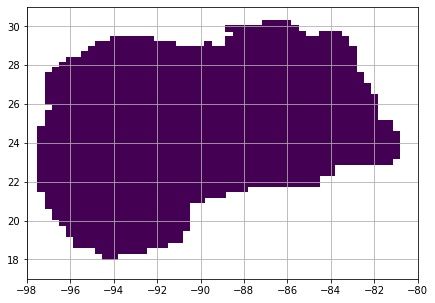

In [112]:
f, ax = plt.subplots(1,1,figsize=(7,5))
ax.pcolor(lons, lats, gulf_mask)
ax.grid(); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

In [122]:
gulf_area = np.nansum(gulf_mask*ecco_monthly_ds.rA.isel(tile=tile_num))
mean_gulf_trend = np.nansum(fitloc*gulf_mask*ecco_monthly_ds.rA.isel(tile=tile_num))/gulf_area 

0.005320970721538065

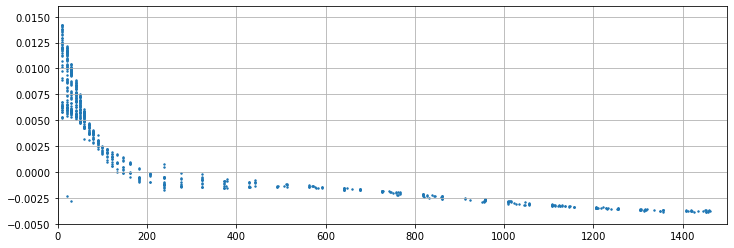

In [141]:
gulf_t_obp = fitloc*gulf_mask
gulf_a_obp = gulf_t_obp - mean_gulf_trend
f,ax = plt.subplots(1,1,figsize=(12,4))
ax.scatter(dep.isel(tile=tile_num)*gulf_mask, \
           gulf_a_obp, s=2); ax.set_xlim([0,1500]); ax.set_ylim([-0.005,0.016]);
ax.grid()

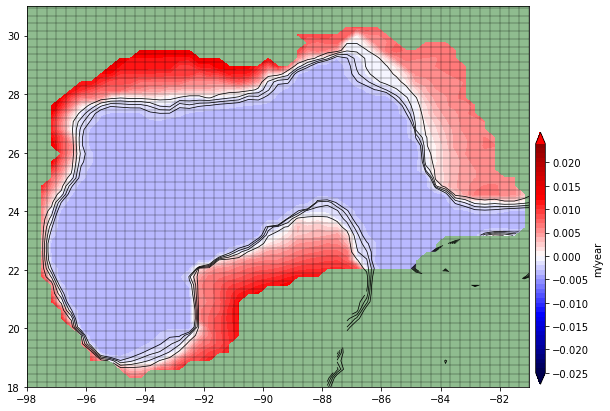

In [149]:
f, ax = plt.subplots(1,1,figsize=(9,7)); clim = [-0.025, 0.025];
colMap = plt.get_cmap('seismic'); colMap.set_over(color='r');
Kc = ax.contourf(lons,lats,gulf_a_obp, levels=np.arange(clim[0], clim[-1],0.001), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both'); 
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.3)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.3)
ax.contour(lons, lats, dep.isel(tile=tile_num), [200, 400, 600, 800], linewidths=0.75, colors='k')
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w,-81]); ax.set_ylim([18,lat_n]);
cbpos = [0.91, 0.13, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='m/year')

In [342]:
ecco_monthly_ds.drF.data.cumsum()[0:25]

array([ 10.      ,  20.      ,  30.      ,  40.      ,  50.      ,
        60.      ,  70.      ,  80.01    ,  90.04    , 100.15    ,
       110.47    , 121.270004, 133.03    , 146.45    , 162.48999 ,
       182.31    , 207.16    , 238.26001 , 276.68    , 323.18    ,
       378.18    , 441.68    , 513.26    , 592.16003 , 677.31006 ],
      dtype=float32)

In [344]:
h = dep.isel(tile=tile_num)
A = ecco_monthly_ds.rA.isel(tile=tile_num)*gulf_mask
As = gulf_area 
# imast = np.array([20,40,60,80,100,120,140,160,180,200,250,300,400,500,600,700,800,900])
imast = ecco_monthly_ds.drF.data.cumsum()[0:25]
AA = []
for i in range(len(imast)):
    AA.append(np.nansum(A.where(h <= imast[i], np.nan)))
    
print(AA/gulf_area)
ii = imast
pbdeps = imast

[0.03639881 0.08740954 0.13355595 0.17453392 0.21270165 0.24269274
 0.25770435 0.2706478  0.28041124 0.2863854  0.29579464 0.30452374
 0.31000218 0.31682637 0.31682637 0.33037728 0.33569545 0.34847972
 0.35598642 0.3640292  0.3728815  0.38171577 0.3878951  0.3967417
 0.40687653]


In [365]:
rho0 = 1035; g = 9.81;
v_cell_t = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF
v_cell_t = v_cell_t.rename({'k': 'layer'})
v_cell_z = np.cumsum(ecco_grid.drF.data)

# density anomaly from trend (max - min) over time series duration 
mean_gulf_rho_trend = np.nansum(rho_a_trend*gulf_mask*ecco_monthly_ds.rA.isel(tile=tile_num))/gulf_area 
gulf_rho_a_trend = rho_a_trend # - mean_gulf_rho_trend
rho_prime = gulf_rho_a_trend.max(dim='time')-gulf_rho_a_trend.min(dim='time')

for m in range(0,len(imast)):
    this_i = np.where(v_cell_z <= ii[m])[0]
    # this_i2 = np.where(v_cell_z <= i2)[0]
    # this_i3 = np.where(v_cell_z <= i3)[0]
    # this_i4 = np.where(v_cell_z <= i4)[0]

    ster1 = (1/rho0)*(rho_prime.isel(layer=np.arange(this_i[0],this_i[-1]+1))*v_cell_t.isel(layer=np.arange(this_i[0],this_i[-1]+1))).sum(dim='layer')
    sterbelow = (1/rho0)*(rho_prime.isel(layer=np.arange(this_i[-1]+1, 50))*v_cell_t.isel(layer=np.arange(this_i[-1]+1, 50))).sum(dim='layer')  
    ster1 = ster1.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)   
    sterbelow = sterbelow.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)  
    ster1 = ster1*gulf_mask; sterbelow = sterbelow*gulf_mask
    deltapb = g*rho0*((A1/As)*sterbelow - (As/A1-1)*(A1/As)*ster1) 
    if  m < 1:
        deltapb = deltapb.expand_dims(dim='zi')
        deltapbz = xr.DataArray(data=deltapb,
        dims=["zi","j", "i"],
        coords=dict(
            i=(["i"], ecco_monthly_ds.i.data), j=(["j"], ecco_monthly_ds.j.data),
            XC=(["j","i"], ecco_monthly_ds.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_monthly_ds.YC.isel(tile=tile_num).data), 
            zi=(["zi"], np.array([1])), 
            ),
        )
    else:
        deltapb = deltapb.expand_dims(dim='zi')
        deltapbzi = xr.DataArray(data=deltapb,
        dims=["zi","j", "i"],
        coords=dict(
            i=(["i"], ecco_monthly_ds.i.data), j=(["j"], ecco_monthly_ds.j.data),
            XC=(["j","i"], ecco_monthly_ds.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_monthly_ds.YC.isel(tile=tile_num).data), 
            zi=(["zi"], np.array([1])),
            ),
        )
        deltapbz = xr.concat([deltapbz,deltapbzi],dim='zi')

In [366]:
zixr = xr.DataArray(data=np.tile(np.array(pbdeps)[:,None,None], (1,270,270)), dims=["zi","j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.i.data), j=(["j"], ecco_monthly_ds.j.data),
        XC=(["j","i"], ecco_monthly_ds.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_monthly_ds.YC.isel(tile=tile_num).data), 
        zi=(["zi"], np.array(pbdeps)),
        ),
)

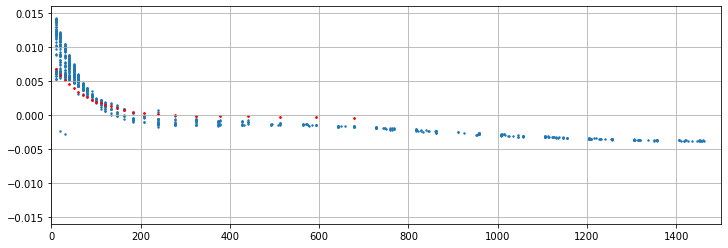

In [368]:
f,ax = plt.subplots(1,1,figsize=(12,4))
offset = 0.005
ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_obp, s=2); 
# ax.scatter(zixr, deltapbz/g/rho0/5 + offset, s=1, color='r')
ax.scatter(pbdeps, deltapbz.mean(dim=['j','i'])/g/rho0/5 + offset, color='r', s=3)
ax.set_xlim([0,1500]); ax.set_ylim([-0.016,0.016]);
ax.grid()

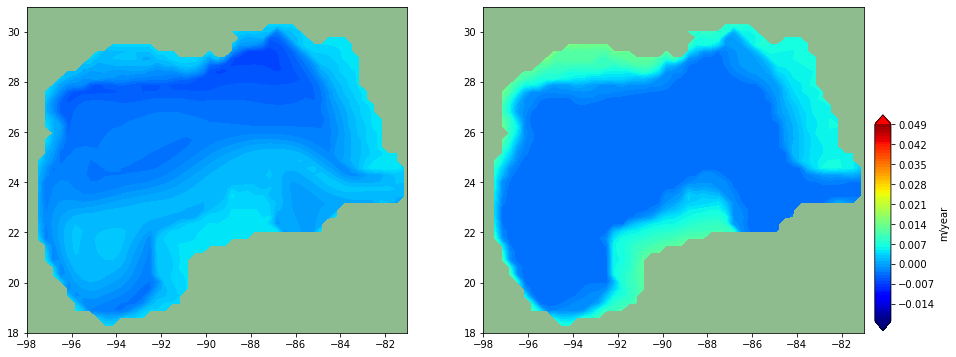

In [364]:
f, (ax,ax2) = plt.subplots(1,2,figsize=(15,6)); clim = [-0.02,0.05];
colMap = plt.get_cmap('jet'); colMap.set_over(color='r');
Kc = ax.contourf(lons,lats,(deltapbz[-1]/g/rho0/5 + offset), levels=np.arange(clim[0], clim[-1],0.001), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both'); 
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w,-81]); ax.set_ylim([18,lat_n]);
Kc = ax2.contourf(lons,lats, gulf_a_obp, levels=np.arange(clim[0], clim[-1],0.001), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both'); 
ax2.set_facecolor('#8FBC8F'); ax2.set_xlim([lon_w,-81]); ax2.set_ylim([18,lat_n]);
cbpos = [0.91, 0.13, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='m/year')